In [10]:
import random
import gym
import numpy as np
from collections import deque
import os
import pickle


from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

ENV_NAME = "CartPole-v1"

GAMMA = 0.95
LEARNING_RATE = 0.001

MEMORY_SIZE = 2_000
RANDOM_RUNS = 100_000
BATCH_SIZE = 256

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.98

In [11]:
os.path.exists("datasets\\best_memory_lightGBM.pkl")

True

In [14]:
class LightQSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.run_memory = []

        # load dataset if exist
        if os.path.exists("datasets\\best_memory_lightGBM.pkl"):
            with open("datasets\\best_memory_lightGBM.pkl", 'rb') as file:
                print("loaded old best memory")
                self.best_memory = pickle.load(file)
        else:
            self.best_memory = []

        if os.path.exists("models\\model_lightGBM.pkl"):
            with open("models\\model_lightGBM.pkl", 'rb') as file:
                self.model = pickle.load(file)
                print('loaded model')
            
            self.isFit=True
            self.exploration_rate=EXPLORATION_MIN*2
        else:
            self.model = MultiOutputRegressor(LGBMRegressor(n_estimators=100, n_jobs=-1))
            self.isFit = False
            self.exploration_rate = EXPLORATION_MAX

    def short_remember(self, state, action, reward, next_state, done):
        self.run_memory.append((state, action, reward, next_state, done))


    def long_remember(self, step):
        self.best_memory.append((self.run_memory.copy(), step))
        self.run_memory.clear()
        # print(len(self.run_memory), len(self.best_memory), MEMORY_SIZE)
        
        if len(self.best_memory) > MEMORY_SIZE:
            # print(len(self.run_memory), len(self.best_memory))
            self.best_memory = sorted(self.best_memory, key=lambda x: x[1])
            self.best_memory = self.best_memory[-MEMORY_SIZE:]
            return True


    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            # print("Random")
            return random.randrange(self.action_space)
        if self.isFit == True:
            # print("Predict")
            q_values = self.model.predict(state)
        else:
            q_values = np.zeros(self.action_space).reshape(1, -1)
            
        return np.argmax(q_values[0])

    @staticmethod
    def generate_bactch(data):
        batch = []
        for b, step in data:
            for (state, action, reward, state_next, terminal) in b:
                pass
    
    def get_Xy(self):
        batch = self.best_memory[-BATCH_SIZE//2:] + random.sample(self.best_memory, BATCH_SIZE//2)
        all_frames = np.array(sum([b for b, step in batch], []), dtype='object')
        len_frames = all_frames.shape[0]
        # print("Total frames to train", len_frames)
        # X_v = np.empty((len_frames, 4))
        # y_v = np.empty((len_frames, 2))

        rewards = all_frames[:, 2]
        states_next = np.concatenate(all_frames[:, 3])
        terminals = all_frames[:, 4]
        states = np.concatenate(all_frames[:, 0])
        actions = all_frames[:, 1].astype('int8')

        # already fit model
        if self.isFit:
            q_values = self.model.predict(states).astype('float')
            q_updates = np.where(terminals, rewards, (rewards + GAMMA * np.amax(self.model.predict(states_next), axis=1)).astype('float'))
        else:
            q_values = np.zeros((len_frames, self.action_space))
            q_updates = rewards
            
        q_v0 = np.where(actions==0, q_updates, q_values[:, 0]).reshape(-1,1)
        #q_v0 = np.where(terminal, rewards, q_v0).reshape(-1, 1) # q_values[0, 1], q_values[1,0], q_values[2, 1]
        q_v1 = np.where(actions==1, q_updates, q_values[:, 1]).reshape(-1,1)
        # q_v1 = np.where(terminal, rewards, q_v1).reshape(-1, 1)# q_values[0, 1], q_values[1,0], q_values[2, 1]

        y_v = np.concatenate((q_v0, q_v1), axis=1)
        X_v = states

        return X_v, y_v

    def experience_replay(self):
        # print("Experience replay")
        if len(self.best_memory) < BATCH_SIZE:
            return
    
        X_v, y_v = self.get_Xy()
        # print(" Training ".center(80, '*'))
        self.model.fit(X_v, y_v)
        self.isFit = True
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)
        
        
class XGBQSolver(LightQSolver):
    def __init__(self, observation_space, action_space):
        super().__init__(observation_space, action_space)
        self.model = XGBRegressor(n_estimators=100)

In [15]:
# %%prun 
env = gym.make(ENV_NAME)
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
dqn_solver = LightQSolver(observation_space, action_space)
run = RANDOM_RUNS-1
steps = []

while True:
    run += 1
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    step = 0
    while True:
        step += 1
        #env.render()
        action = dqn_solver.act(state)
        state_next, reward, terminal, info = env.step(action)
        reward = reward if not terminal else -reward
        state_next = np.reshape(state_next, [1, observation_space])
        dqn_solver.short_remember(state, action, reward, state_next, terminal)
        state = state_next
        if terminal: 
            print("#", end='')
            break

    steps.append(step)
    dqn_solver.long_remember(step)

    if run % 100 == 0 and run >= RANDOM_RUNS:
        dqn_solver.experience_replay()

        print("\nRun: " + str(run) + ", exploration: " + str(round(dqn_solver.exploration_rate,3)) + #", last score: " + str(step) + 
            f" | Best memory -> Best: {dqn_solver.best_memory[-1][-1]}, Mean: {np.mean([x[1] for x in dqn_solver.best_memory]):.2f}, Worst: {dqn_solver.best_memory[0][-1]}", 
            f"| Last 100 runs -> Best: {max(steps)}, Mean: {np.mean(steps):.2f}, Worst: {min(steps)}")
        
        steps.clear()

loaded old best memory
loaded model
#
Run: 100000, exploration: 0.098 | Best memory -> Best: 500, Mean: 327.09, Worst: 236 | Last 100 runs -> Best: 208, Mean: 208.00, Worst: 208
####################################################################################################
Run: 100100, exploration: 0.096 | Best memory -> Best: 500, Mean: 327.30, Worst: 237 | Last 100 runs -> Best: 393, Mean: 144.26, Worst: 23
##########################################################

KeyboardInterrupt: 

## Plot rewards and obs

(106280,) (106280, 2) (106280,)


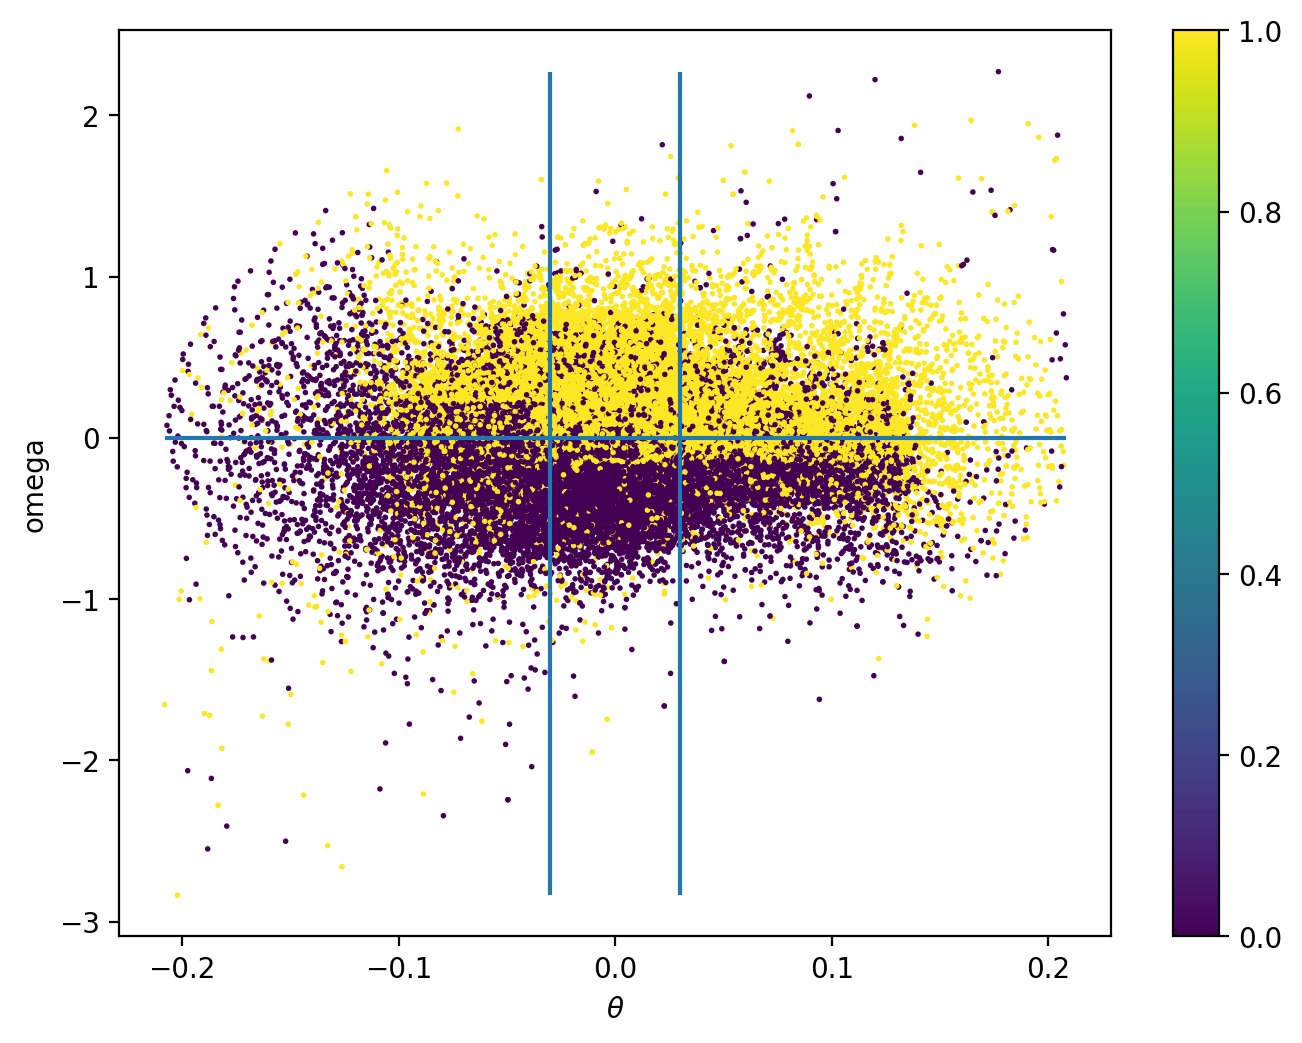

In [28]:
import matplotlib.pyplot as plt

X, y = dqn_solver.get_Xy()

omega = X[:, 3]
theta = X[:, 2]
color = np.argmax(y, axis=1)

print(omega.shape, y.shape, color.shape)

plt.figure(figsize=(8, 6), dpi=200)
plt.scatter(theta, omega, c=color, s=1)
plt.vlines([0.03, -0.03], ymin=min(omega), ymax=max(omega))
plt.hlines([0], xmin=min(theta), xmax=max(theta))
plt.xlabel(r'$\theta$')
plt.ylabel('omega')
plt.colorbar();

In [ ]:
# [print(b[0][0], x) for b, x in dqn_solver.best_memory];
# dqn_solver.exploration_rate=0.10
# round(BATCH_SIZE*(1-dqn_solver.exploration_rate)), round(BATCH_SIZE*dqn_solver.exploration_rate)

# # save dataset
# with open("datasets\\best_memory_lightGBM.pkl", 'wb') as file:
#     print(file)
#     pickle.dump(dqn_solver.best_memory, file)

# with open("models\\model_lightGBM.pkl", 'wb') as file:
#     print(file, dqn_solver.model)
#     pickle.dump(dqn_solver.model, file)

# # previous method
# X = np.empty((len_frames, 4))
# y = np.empty((len_frames, 2))
# step_cntr = 0

# for b, step in batch:
#     for i, (state, action, reward, state_next, terminal) in enumerate(b):
#         #print(i+step_cntr, end=",")
#         q_update = reward
#         if not terminal:
#             if dqn_solver.isFit:
#                 q_update = (reward + GAMMA * np.amax(dqn_solver.model.predict(state_next)[0]))
#                 # print(self.model.predict(state_next))
#             else:
#                 q_update = reward
#         if dqn_solver.isFit:
#             q_values = dqn_solver.model.predict(state)
#         else:
#             q_values = np.zeros(dqn_solver.action_space).reshape(1, -1)
            
#         q_values[0][action] = q_update

#         X[i+step_cntr] = state[0]
#         y[i+step_cntr] = q_values[0]
                    
#     step_cntr += step

In [ ]:
t = [["ok", 1], ["?", 3]]
t.append(["va", 1])
t.append(["come", 3])

sorted(t, key=lambda x: x[1]), t

In [ ]:
(X[:] == X_v[:]).all(), (y[:] == y_v[:]).all(), y_v[499], y[499], X

In [ ]:
# print(f"(Best: {dqn_solver.best_memory[-1][-1]}, Worst: {dqn_solver.best_memory[0][-1]})")
# dqn_solver.best_memory.append(("test", 11))
# dqn_solver.best_memory.append(("test", 11))
# dqn_solver.best_memory.append(("test", 11))
# dqn_solver.best_memory.append(("test", 11))
# dqn_solver.best_memory.append(("test", 11))
# dqn_solver.best_memory.append(("test", 11))
# dqn_solver.best_memory.append(("test", 11))
# # print([x[1] for x in sorted(dqn_solver.best_memory, key=lambda x: x[1])])
# if len(dqn_solver.best_memory) > MEMORY_SIZE:
#     # print(len(dqn_solver.run_memory), len(dqn_solver.best_memory))
#     dqn_solver.best_memory = sorted(dqn_solver.best_memory, key=lambda x: x[1])
#     dqn_solver.best_memory = dqn_solver.best_memory[-MEMORY_SIZE:]
    
# print(f"(Best: {dqn_solver.best_memory[-1][-1]}, Worst: {dqn_solver.best_memory[0][-1]})")

In [ ]:
batch = []
step_counter = 0
for bm in dqn_solver.best_memory[-100:]:
    for i,(state, action, reward, state_next, terminal) in enumerate(bm[0]):
        pass
        #print(i+step_counter)
    step_counter += bm[1]
sum([x[1] for x in dqn_solver.best_memory[-100:]])

In [ ]:
best_params = []
best_index = []
all_data = deque(maxlen=100)
max_len = 100
import bisect

for i in range(1000):
    r = random.randint(0, 100)
    all_data.append([r,str(i)])

    if len(best_params) < max_len:
        best_params.append(r)
        if len(best_params) == max_len-1:
            best_params = sorted(best_params)

    bisect.insort(best_params, r)
    best_params = best_params[-max_len:]
        # best_index = np.argsort(best_params)[-10:]
    
        
print(type(all_data))
print(type(sorted(all_data, key=lambda x: x[1])[:4]))
all_data.append(5)


In [ ]:
best_params.insert(len(np.array(best_params)[(np.array(best_params) < 20)]), 20)
print(best_params)


In [ ]:
import bisect

print(best_params)

def bisect_insert(best_params):
    bisect.insort(best_params, 20)
    return best_params[-10:]

def sorted_insert(best_params):
    best_params.append(20)
    best_params = sorted(best_params)
    return best_params[-10:]

def sorted_numpy(best_params, arg):
    #print(arg, best_params[best_params<arg])
    best_params = np.insert(best_params, len(best_params[best_params<arg]), arg)[-max_len:]
    return best_params

# %timeit bisect_insert(best_params)
# %timeit sorted_numpy(np.array(best_params).copy(), 20)
print(sorted_numpy(np.array(best_params).copy(), 95))

In [ ]:
import time 

times = []
best_par = np.array(best_params).copy()

for i in range(100000):
    t = time.time()
    best_par = sorted_numpy(best_par, random.randint(70, 95))
    t2 = time.time()-t
    times.append(t2)
    if t2 > 0:
        pass
        #print(best_par, f"{t2:.20f} s")

sum(times)/len(times) * 1e6

In [ ]:
steps = []
for i in range(1000):
    env.reset()
    action = 0
    prev_action = 0
    step = 0
    while True:
        state_next, reward, terminal, info = env.step(action)
        step+=1
        #print(state_next, action)
        if action == 0:
            action=1
        else:
            action=0

        # check position
        if state_next[0] < -0.02 and state_next [2]>0.1 and state_next[1]<-0.9:
            action=1
        elif state_next[0] > 0.02 and state_next [2]<-0.1:
            action=0
        
        if terminal:
            print(state_next, action)
            break

    steps.append(step)

np.mean(steps), np.sort(steps)[-10:]

In [ ]:
steps_rand = []
X = {}
y = []
for i in range(10000):
    env.reset()
    action = 0
    step = 0
    X[i] = []

    while True:
        state_next, reward, terminal, info = env.step(action)
        step+=1
        action = random.randrange(2)
        
        if terminal:
            break

        X[i].append(list(state_next))
    steps_rand.append(step)
    
np.mean(steps_rand), np.max(steps_rand), np.sort(steps_rand)[-100:]

In [ ]:
[X[i] for marg in list(np.argsort(steps_rand)[-100:])]

## XGB MultiOutput regressor

In [ ]:
# xgboost test
import argparse
from typing import Dict, Tuple, List

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

def plot_predt(y: np.ndarray, y_predt: np.ndarray, name: str) -> None:
    s = 25
    plt.scatter(y[:, 0], y[:, 1], c="navy", s=s, edgecolor="black", label="data")
    plt.scatter(
        y_predt[:, 0], y_predt[:, 1], c="cornflowerblue", s=s, edgecolor="black", label='prediction'
    )
    plt.xlim([-1, 2])
    plt.ylim([-1, 2])
    plt.legend()
    plt.show()


def gen_circle() -> Tuple[np.ndarray, np.ndarray]:
    "Generate a sample dataset that y is a 2 dim circle."
    rng = np.random.RandomState(1994)
    X = 200 * rng.rand(10000, 1) - 100
    y = np.array([np.pi * np.sin(X).ravel(), np.pi * np.cos(X).ravel()]).T
    y[::5, :] += 0.5 - rng.rand(10000//5, 2)
    y = y - y.min()
    y = y / y.max()
    return X, y


def rmse_model(plot_result: bool):
    """Draw a circle with 2-dim coordinate as target variables."""
    X, y = gen_circle()
    # Train a regressor on it
    reg = xgb.XGBRegressor(tree_method="hist", n_estimators=128)

    batch_size = 1000
    first_fit = True
    for b in range(len(X)//batch_size): #batch size
        Xp, yp = X[b*batch_size:(b+1)*batch_size],  y[b*batch_size:(b+1)*batch_size]
        if first_fit:
            reg.fit(Xp, yp)
            first_fit=False
        else:
            reg = reg.fit(Xp, yp, xgb_model=reg.get_booster())
            y_predt = reg.predict(Xp)
            print(mean_absolute_error(yp, y_predt))
            # plt.plot(Xp)
            # plt.show()
            # plot_predt(yp, y_predt, 'multi')

    #plot_predt(yp, yp, "multi")
    y_predt = reg.predict(X)
    print(mean_absolute_error(y, y_predt))
    if plot_result:
        plot_predt(y, y_predt, "multi")


def rmse_model_batch(plot_result: bool):
    """Draw a circle with 2-dim coordinate as target variables."""
    X, y = gen_circle()
    # Train a regressor on it
    reg = xgb.XGBRegressor(tree_method="hist", n_estimators=64)
    reg.fit(X, y,)# eval_set=[(X, y)])

    y_predt = reg.predict(X)
    print(mean_absolute_error(y, y_predt))

    if plot_result:
        plot_predt(y, y_predt, "multi")

In [ ]:
rmse_model(True)
rmse_model_batch(True)